# Simulation-based inference (SBI) notebook



Neural infrence framework for infer interstellar gas temperature in galaxies across 4 dimensions (velocity and spatial dimensions)

In this notebook:
A neural infrence framework for infer interstellar gas temperature spatial dimensions


# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/ML/sbi
!ls

In [ ]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/ML/sbi


# Install packages

In [ ]:
!pip install sbi --quiet

# Libraries

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import scipy as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


from sbi import utils
from sbi import analysis
from sbi.inference import SNPE #, simulate_for_sbi, prepare_for_sbi
from sbi.neural_nets import posterior_nn

from sklearn.decomposition import PCA

from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs         import WCS

import h5py
import pickle

from pathlib import Path

# set seed for numpy and torch
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


%matplotlib inline

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print("Is CUDA enabled?",torch.cuda.is_available())

device:  cpu
device_count:  0
Torch version:  2.5.1+cu121
torch.version.cuda:  12.1
Is CUDA enabled? False


# Paths

In [ ]:
base_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML/')

sbi_path = base_path / 'sbi'
checkpoint_path  = sbi_path / 'checkpoints'

data_path       = base_path / 'data'
uma_data_path   = data_path / 'UMA'
seta_data_path  = data_path / 'seta'
saury_data_path = data_path / 'saury'

# Outputs data from simulations: density, temperature and velocity
rho_file  = saury_data_path / 'rho_016.fits'
temp_file = saury_data_path / 'T_016.fits'
vz_file   = saury_data_path / 'vz_016.fits'

# Brightness Tb summary statistics with a neural network
This is a simulation-based inference of interstellar gas temperature along velocity axis. The simulator model generates emission Tb (v) spectra (256 channels) and I use a convolutional neural network as summary statistics extractor.

---

`sbi` offers functionality to learn summary statistics from (potentially high-dimensional) simulation outputs with a neural network. In `sbi`, this neural network is referred to as `embedding_net`. If an `embedding_net` is specified, the simulation outputs are passed through the `embedding_net`, whose outputs are then passed to the neural density estimator. The parameters of the `embedding_net` are learned together with the parameters of the neural density estimator.

# Read training dataset

In [ ]:
# Parameters
# Train on 1 million spectra
n_train = 1_046_576

# Test on 2000 spectra
n_test = 2000

spectrum_length = 256
vector_length = 64

In [ ]:
# Const
m_h = 1.6737236e-27
nz  = 1024
dz  = 200./nz # in pc
L = np.arange(0., nz, 1) * dz # in pc


#Velocity range and channel spacing
vmin = -40. # in km/s
vmax = 40.  # in km/s
dv   = 0.3125 # in km.s-1
v    = np.arange(vmin, vmax, dv) # Velocity axis in km/s

print(len(v))

256


In [ ]:
# Compute the factor by which to reduce the number of channels
factor = nz // vector_length

# Average channels
L128 = L.reshape(vector_length, factor).mean(axis=1)
L128.shape

(64,)

## Emission data cube

In [ ]:
data_file = saury_data_path / 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_0.fits'
cube, hdr = fits.getdata(data_file, header=True)
cube = cube[:256, :, :]
print(cube.shape)

(256, 512, 512)


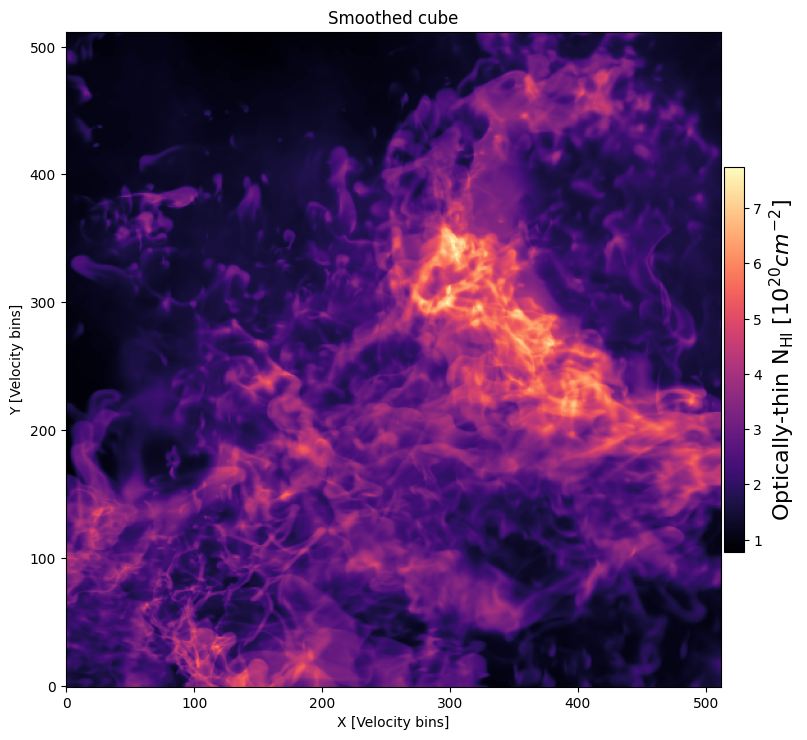

In [ ]:
WHI = np.sum(cube, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI * dv # In unit of 10^20 cm-2

plt.figure(figsize=(10,10))
plt.imshow(NHI_thin, cmap='magma', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20} cm^{-2}$]', size=16)

plt.title('Smoothed cube')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

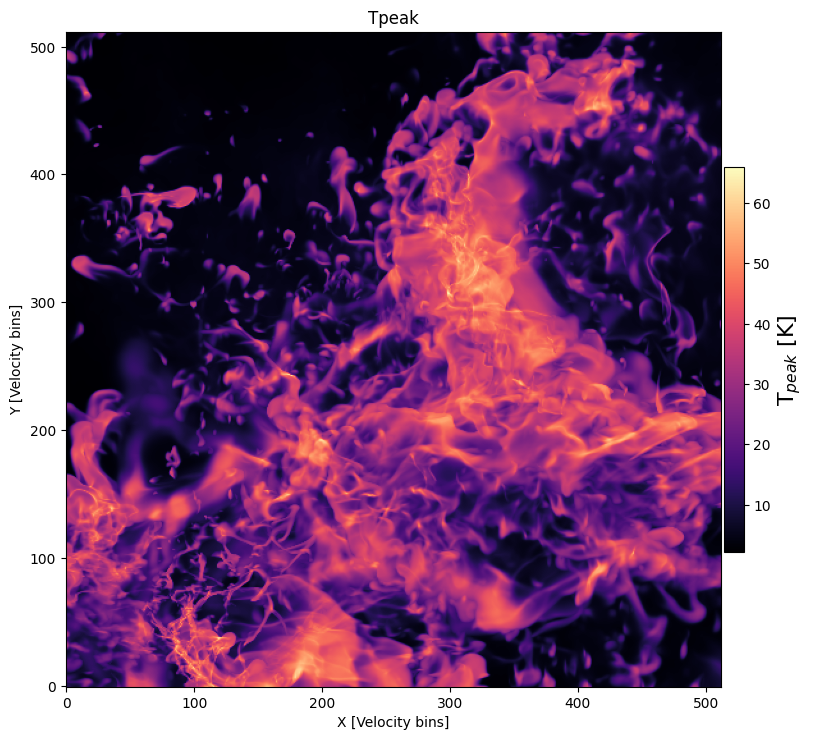

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(cube, axis=0), cmap='magma', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('T$_{peak}$ [K]', size=16)

plt.title('Tpeak')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

## Absorption data cube

In [ ]:
tau_data_file = saury_data_path / 'tau_n01_pw02_vs12_512_thick_256chan_quarter_0.fits'
tau_cube, hdr = fits.getdata(tau_data_file, header=True)
tau_cube = tau_cube[:256, :, :]

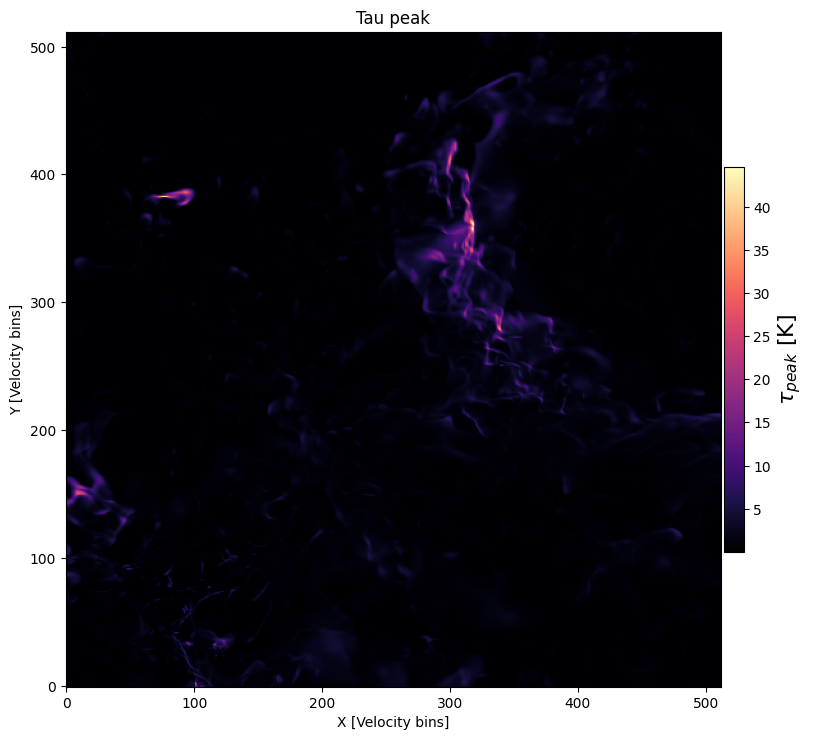

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(tau_cube, axis=0), cmap='magma', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label(r'$\tau_{peak}$ [K]', size=16)

plt.title('Tau peak')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

## Reshape the data cubes

In [ ]:
# Here I show the process of 1 data cube only

nchan, ny, nx = cube.shape
nspec = nx * ny

# cube_rs = cube.reshape(-1, nchan, order='C')
cube_rs = cube.reshape(nchan, ny * nx).T
tau_cube_rs = tau_cube.reshape(nchan, ny * nx).T

## Emission data cube 1

In [ ]:
data_file1 = saury_data_path / 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_1.fits'
cube1, hdr1 = fits.getdata(data_file1, header=True)
cube1 = cube1[:256, :, :]

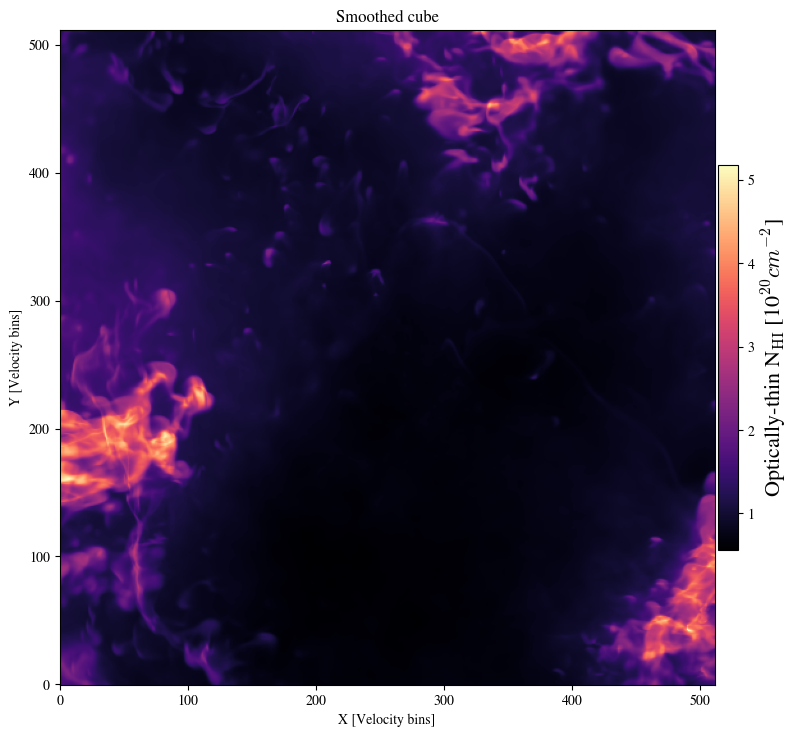

In [ ]:
WHI1 = np.sum(cube1, axis=0)
NHI1_thin = 1.8224 * 1.e-2 * WHI1 * dv # In unit of 10^20 cm-2

plt.figure(figsize=(10,10))
plt.imshow(NHI1_thin, cmap='magma', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20} cm^{-2}$]', size=16)

plt.title('Smoothed cube')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

## Absorption data cube 1

In [ ]:
tau_data_file1 = saury_data_path / 'tau_n01_pw02_vs12_512_thick_256chan_quarter_1.fits'
tau_cube1, hdr1 = fits.getdata(tau_data_file1, header=True)
tau_cube1 = tau_cube1[:256, :, :]

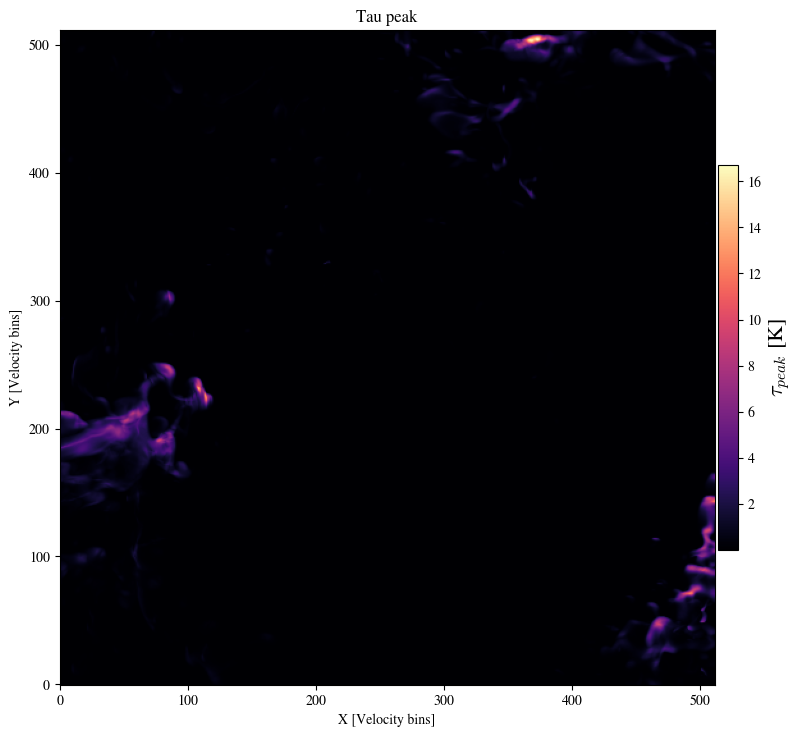

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(tau_cube1, axis=0), cmap='magma', origin='lower') #, vmin=0., vmax=3.)

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label(r'$\tau_{peak}$ [K]', size=16)

plt.title('Tau peak')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

In [ ]:
# Here I show the process of 1 data cube only

nchan1, ny1, nx1 = cube1.shape
nspec1 = nx1 * ny1

# cube_rs = cube.reshape(-1, nchan, order='C')
cube1_rs = cube1.reshape(nchan1, ny1 * nx1).T
tau_cube1_rs = tau_cube1.reshape(nchan1, ny1 * nx1).T

# Combine all data cubes: Brightness emission temperatures

In [ ]:
# Combine all data cubes: more than 1 million spectra
cube_rs = np.concatenate([cube1_rs,
                          cube2_rs,
                          cube3_rs,
                          cube4_rs],
                          axis=0)

# Read simulation data: Density, temperature and velocity

In [ ]:
# READ Output data from simulations:
with fits.open(rho_file) as hdu_list_rho:
    dens = hdu_list_rho[0].data

with fits.open(temp_file) as hdu_list_T:
    temp = hdu_list_T[0].data

with fits.open(vz_file) as hdu_list_vz:
    velz = hdu_list_vz[0].data

dens = dens/(m_h*1000.) # cm-3
velz = velz / 1.e5      # cm/s to km/s

/content/gdrive/MyDrive/Colab Notebooks/ML/data/saury/rho_016.fits
/content/gdrive/MyDrive/Colab Notebooks/ML/data/saury/T_016.fits
/content/gdrive/MyDrive/Colab Notebooks/ML/data/saury/vz_016.fits


In [ ]:
print(dens.shape)
print(temp.shape)
print(velz.shape)

(1024, 512, 512)
(1024, 512, 512)
(1024, 512, 512)


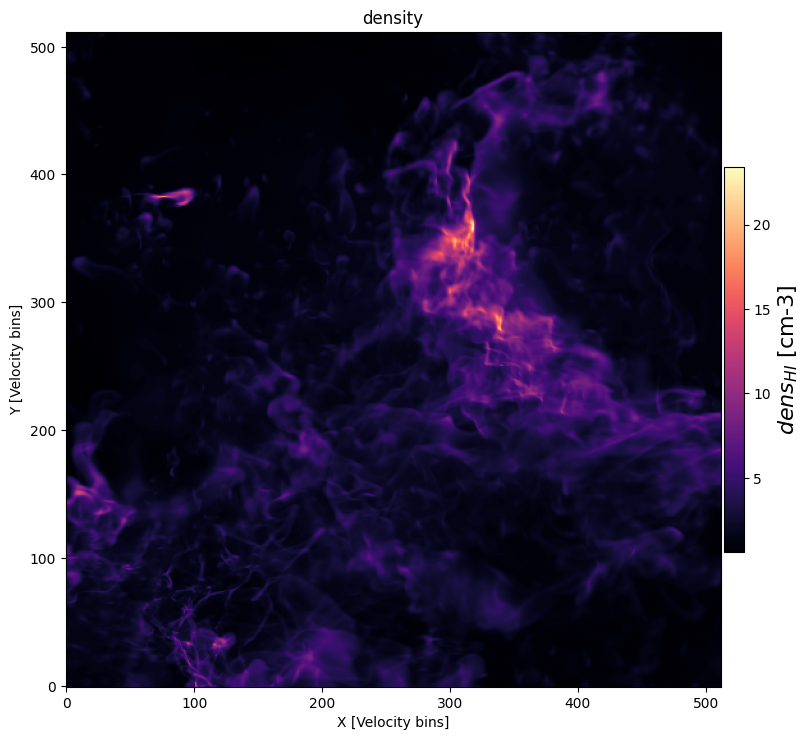

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.mean(dens, axis=0), cmap='magma', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label(r'$dens_{HI}$ [cm-3]', size=16)

plt.title('density')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

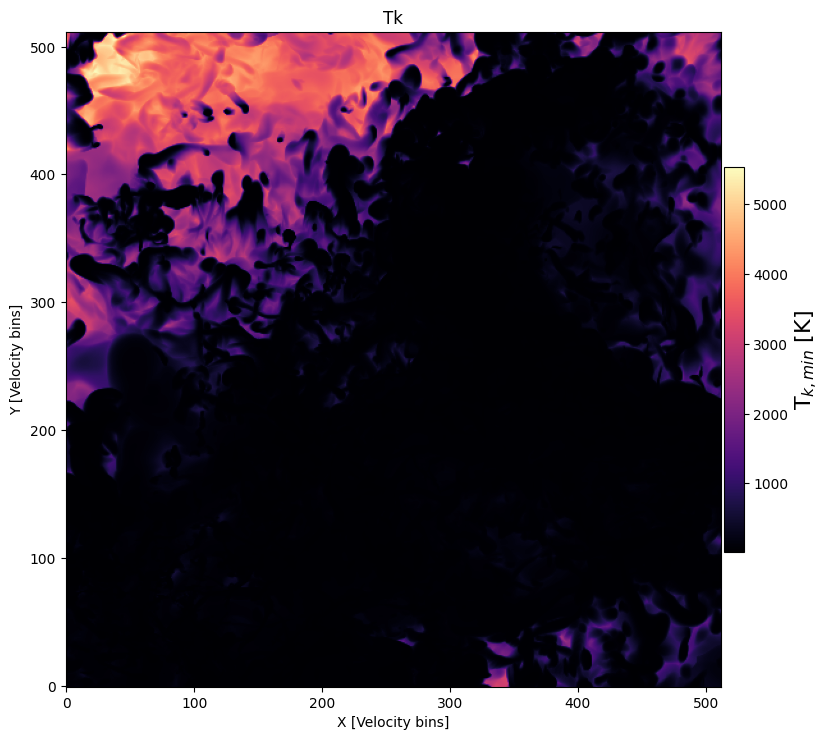

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.min(temp, axis=0), cmap='magma', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('T$_{k, min}$ [K]', size=16)

plt.title('Tk')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

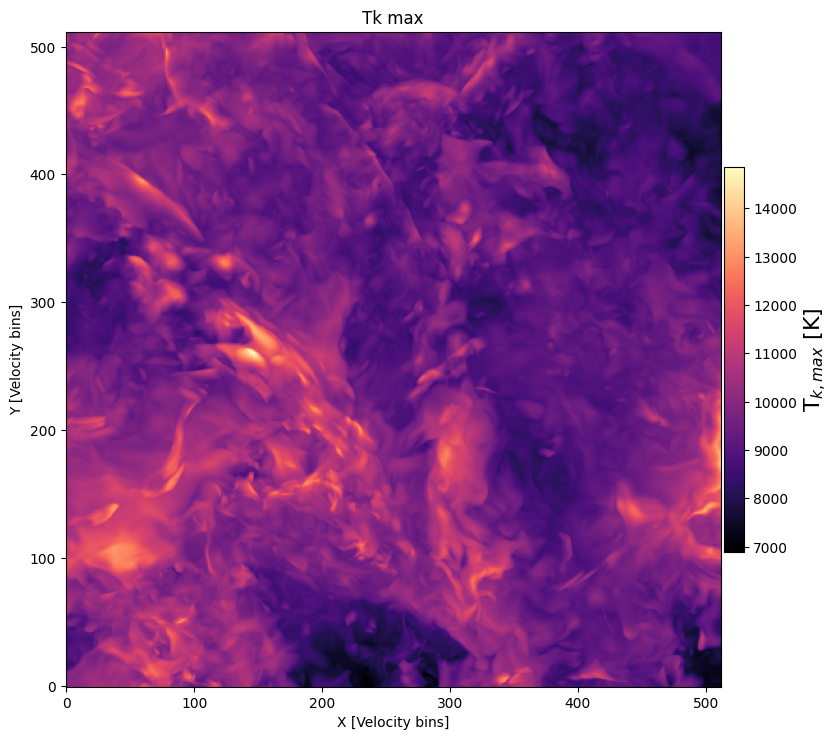

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(temp, axis=0), cmap='magma', origin='lower')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('T$_{k, max}$ [K]', size=16)

plt.title('Tk max')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

# Temperature in physical space: convert to log10

In [ ]:
temp = np.log10(temp)

In [ ]:
dens.max()

3458.6055

In [ ]:
dens.min()

0.098909415

In [ ]:
densmin = dens.min()

In [ ]:
temp.min()

1.2470049

In [ ]:
tk_min = temp.min()
tk_max = temp.max()

In [ ]:
temp.max()

4.172016

In [ ]:
# Number of all spectra for training
npixels = 1024 * 1024
nz = 1024
dens_rs = dens.reshape(nz, npixels).T
temp_rs = temp.reshape(nz, npixels).T
velz_rs = velz.reshape(nz, npixels).T

In [ ]:
# Average channels
dens_rs = dens_rs.reshape(-1, vector_length, factor).mean(axis=2)

# Average channels
velz_rs = velz_rs.reshape(-1, vector_length, factor).mean(axis=2)

# Average channels
temp_rs = temp_rs.reshape(-1, vector_length, factor).mean(axis=2)

# Plot spectra and profiles

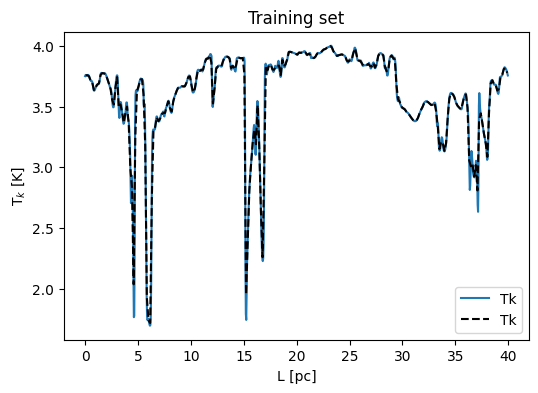

In [ ]:
# Spectrum in training set

i = 200
j = 100
plt.figure(figsize=(6,4))
plt.plot(L, temp[:, j, i], label='Tk')
plt.plot(L128, temp_rs[j*512+i, :], 'k--', label='Tk')

plt.title('Training set')
plt.xlabel('L [pc]')
plt.ylabel('T$_k$ [K]')

plt.legend()

plt.show()

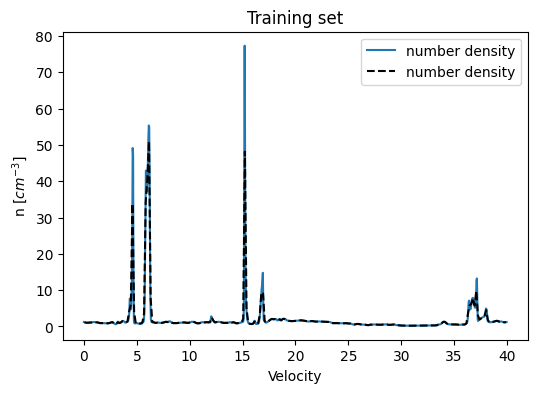

In [ ]:
# Spectrum in training set

i = 200
j = 100
plt.figure(figsize=(6,4))
plt.plot(L, dens[:, j, i], label='number density')
plt.plot(L128, dens_rs[j*512+i, :], 'k--', label='number density')

plt.title('Training set')
plt.xlabel('Velocity')
plt.ylabel('n [$cm^{-3}$]')

plt.legend()

plt.show()

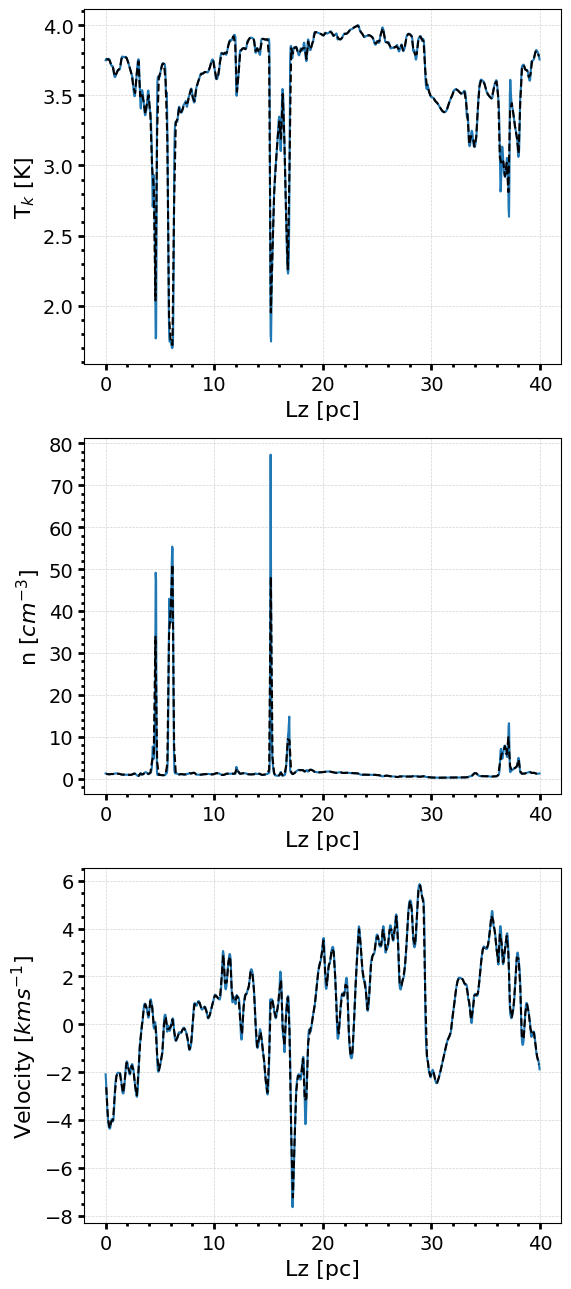

In [ ]:
i = 200
j = 100

indx = j*512 + i
#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

#
ax1 = axs[0]
ax1.plot(L, temp[:, j, i], label='Tk')
ax1.plot(L128, temp_rs[indx, :], 'k--', label='Tk')

ax1.set_xlabel('Lz [pc]', fontsize=16)
ax1.set_ylabel(r'T$_k$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)

ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax2 = axs[1]
ax2.plot(L, dens[:, j, i], label='number density')
ax2.plot(L128, dens_rs[indx, :], 'k--', label='number density')

# ax2.set_title('Training set')
ax2.set_xlabel('Lz [pc]', fontsize=16)
ax2.set_ylabel('n [$cm^{-3}$]', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)

ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax4 = axs[2]
ax4.plot(L, velz[:, j, i], label='Velocity in z direction')
ax4.plot(L128, velz_rs[indx, :], 'k--', label='Velocity in z direction')

# ax3.set_title('Training set')
ax4.set_xlabel('Lz [pc]', fontsize=16)
ax4.set_ylabel('Velocity [$km s^{-1}$]', fontsize=16)

ax4.minorticks_on()
ax4.tick_params(axis='x', labelsize=14, pad=4)
ax4.tick_params(axis='y', labelsize=14)
ax4.tick_params(which='both', width=2)
ax4.tick_params(which='major', length=4)
ax4.tick_params(which='minor', length=2)

ax4.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


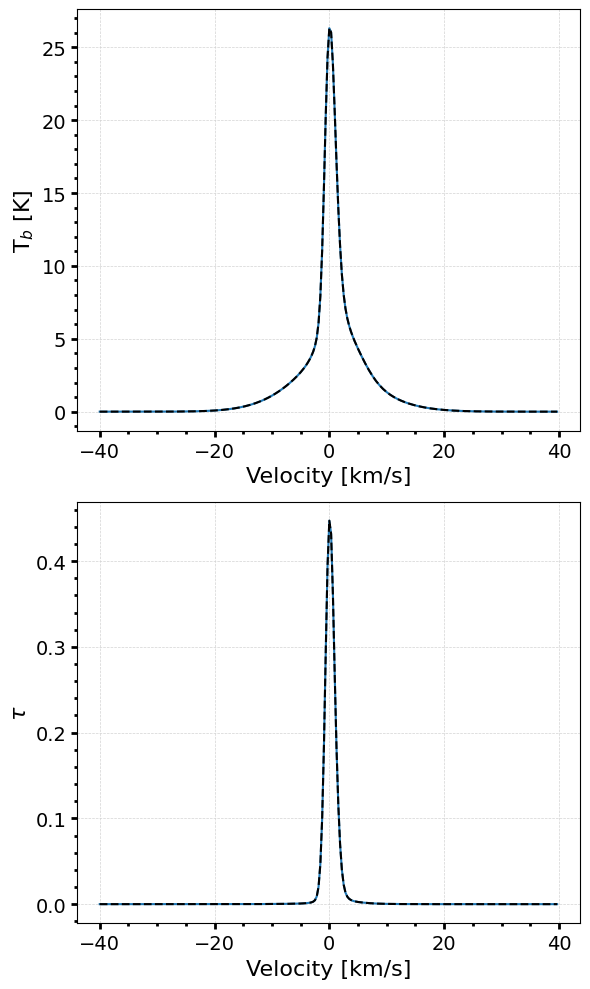

In [ ]:
i = 200
j = 100

indx = j*512 + i
#
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

#
ax1 = axs[0]
ax1.plot(v, cube[:, j, i], label='Tb')
ax1.plot(v, cube_rs[indx, :], 'k--', label='Tb')

ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)

ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax2 = axs[1]
ax2.plot(v, tau_cube[:, j, i], label=r'$\tau$')
ax2.plot(v, tau_cube_rs[indx, :], 'k--', label=r'$\tau$')

ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)

ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


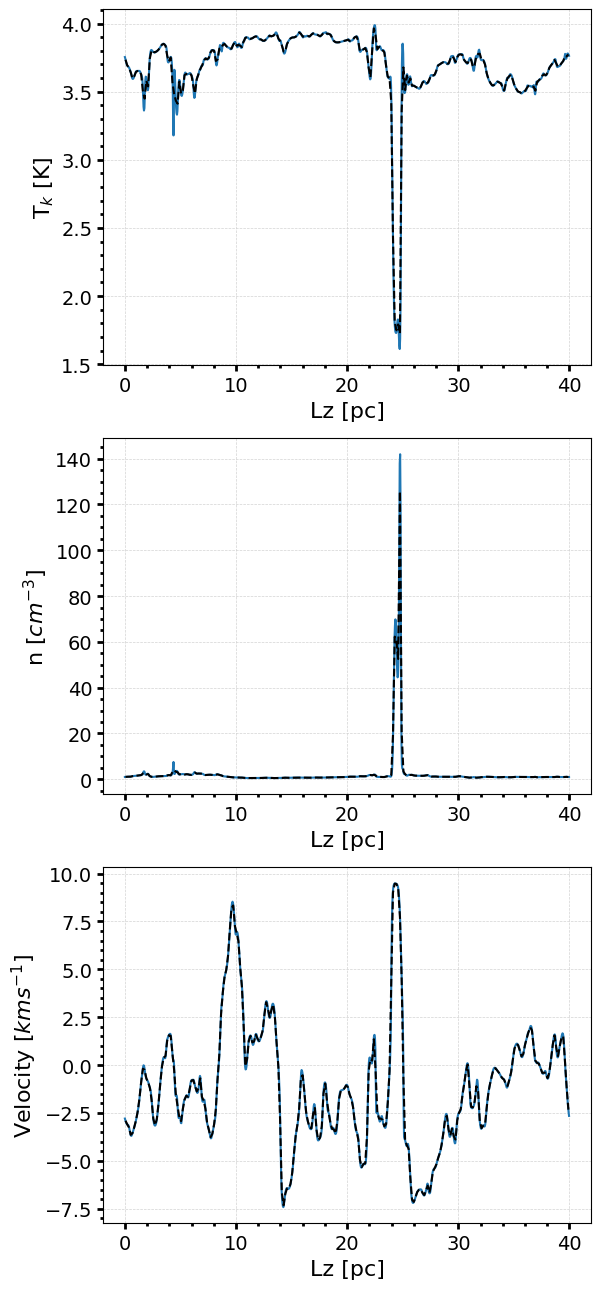

In [ ]:
i = 125
j = 321

indx = j*512 + i
#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

#
ax1 = axs[0]
ax1.plot(L, temp[:, j, i], label='Tk')
ax1.plot(L128, temp_rs[indx, :], 'k--', label='Tk')

ax1.set_xlabel('Lz [pc]', fontsize=16)
ax1.set_ylabel(r'T$_k$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)

ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(L, dens[:, j, i], label='number density')
ax2.plot(L128, dens_rs[indx, :], 'k--', label='number density')

# ax2.set_title('Training set')
ax2.set_xlabel('Lz [pc]', fontsize=16)
ax2.set_ylabel('n [$cm^{-3}$]', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)

ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax4 = axs[2]
ax4.plot(L, velz[:, j, i], label='Velocity in z direction')
ax4.plot(L128, velz_rs[indx, :], 'k--', label='Velocity in z direction')

# ax3.set_title('Training set')
ax4.set_xlabel('Lz [pc]', fontsize=16)
ax4.set_ylabel('Velocity [$km s^{-1}$]', fontsize=16)

ax4.minorticks_on()
ax4.tick_params(axis='x', labelsize=14, pad=4)
ax4.tick_params(axis='y', labelsize=14)
ax4.tick_params(which='both', width=2)
ax4.tick_params(which='major', length=4)
ax4.tick_params(which='minor', length=2)

ax4.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


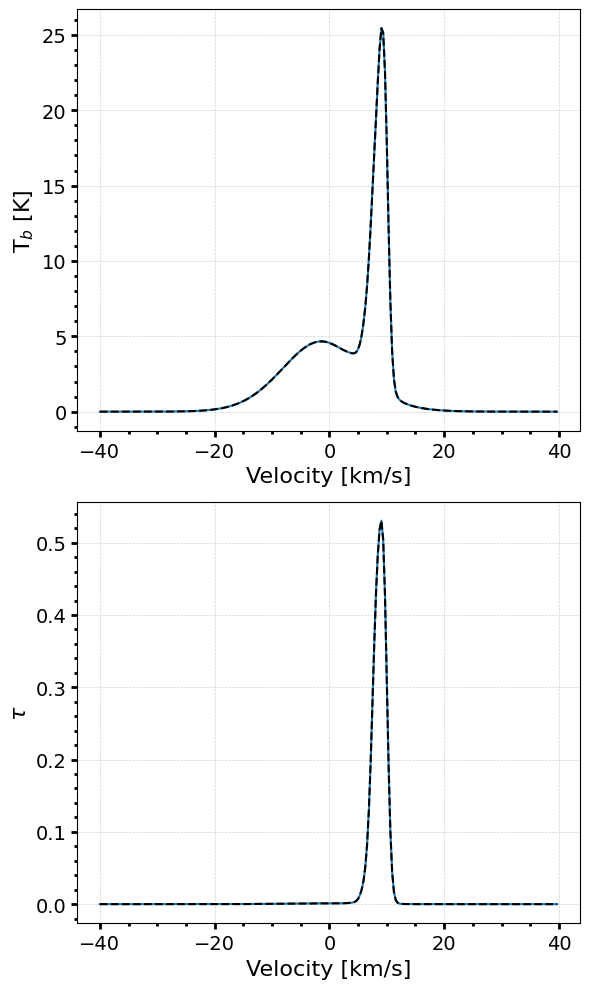

In [ ]:
i = 125
j = 321

indx = j*512 + i
#
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

#
ax1 = axs[0]
ax1.plot(v, cube[:, j, i], label='Tb')
ax1.plot(v, cube_rs[indx, :], 'k--', label='Tb')

ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)

ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax2 = axs[1]
ax2.plot(v, tau_cube[:, j, i], label=r'$\tau$')
ax2.plot(v, tau_cube_rs[indx, :], 'k--', label=r'$\tau$')

ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)

ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


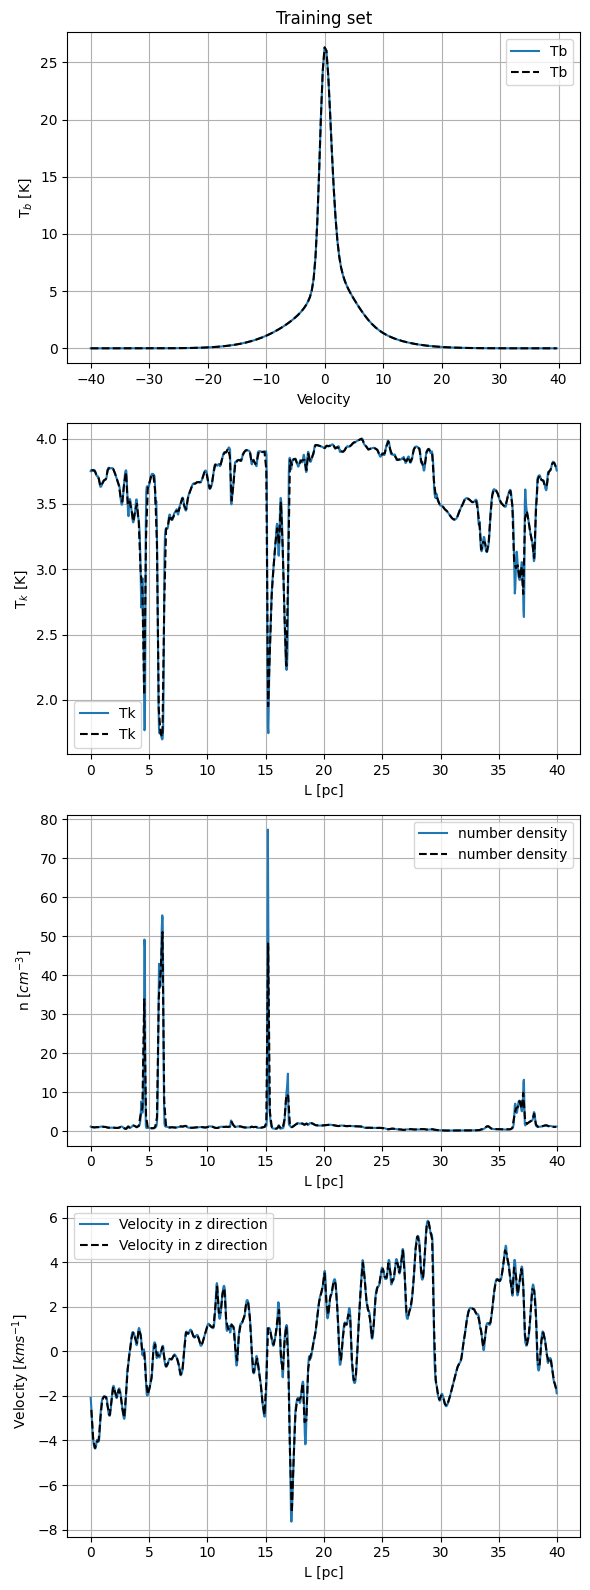

In [ ]:
i = 200
j = 100

indx = j*512 + i
#
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(6, 16))

ax1 = axs[0]
ax1.plot(v, cube[:, j, i], label='Tb')
ax1.plot(v, cube_rs[indx, :], 'k--', label='Tb')

ax1.set_title('Training set')
ax1.set_xlabel('Velocity')
ax1.set_ylabel('T$_b$ [K]')
ax1.grid()
ax1.legend()



#
ax2 = axs[1]
ax2.plot(L, temp[:, j, i], label='Tk')
ax2.plot(L128, temp_rs[indx, :], 'k--', label='Tk')

# ax2.set_title('Training set')
ax2.set_xlabel('L [pc]')
ax2.set_ylabel('T$_k$ [K]')
ax2.grid()
ax2.legend()



#
ax3 = axs[2]
ax3.plot(L, dens[:, j, i], label='number density')
ax3.plot(L128, dens_rs[indx, :], 'k--', label='number density')

# ax3.set_title('Training set')
ax3.set_xlabel('L [pc]')
ax3.set_ylabel('n [$cm^{-3}$]')
ax3.grid()
ax3.legend()



#
ax4 = axs[3]
ax4.plot(L, velz[:, j, i], label='Velocity in z direction')
ax4.plot(L128, velz_rs[indx, :], 'k--', label='Velocity in z direction')

# ax3.set_title('Training set')
ax4.set_xlabel('L [pc]')
ax4.set_ylabel('Velocity [$km s^{-1}$]')
ax4.grid()
ax4.legend()



# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


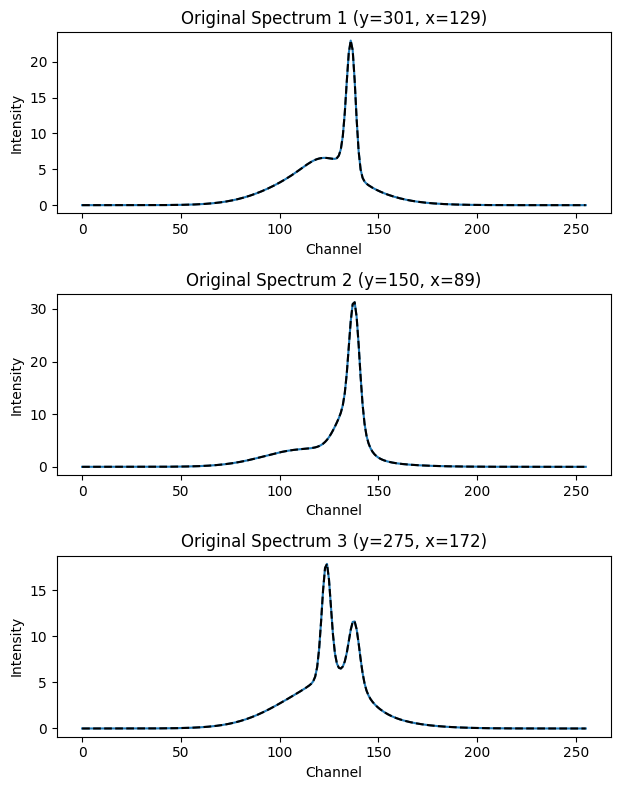

In [ ]:
n = 3

# Randomly select n spectra
indices = np.random.choice(ny * nx, n, replace=False)

# Alternatively, select sequential spectra
# indices = np.arange(n)

# Convert 1D indices to (y, x) pairs
ys, xs = np.divmod(indices, nx)

# Extract spectra from the original data cube and reshaped array
original_spectra = np.array([cube[:, y, x] for y, x in zip(ys, xs)])
reshaped_spectra = cube_rs[indices]

# Plot the original and reshaped spectra
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(n, 2, 2 * i + 1)
    plt.plot(original_spectra[i])
    plt.plot(reshaped_spectra[i], 'k--')
    plt.title(f'Original Spectrum {i+1} (y={ys[i]}, x={xs[i]})')
    plt.xlabel('Channel')
    plt.ylabel('Intensity')

plt.tight_layout()
plt.show()


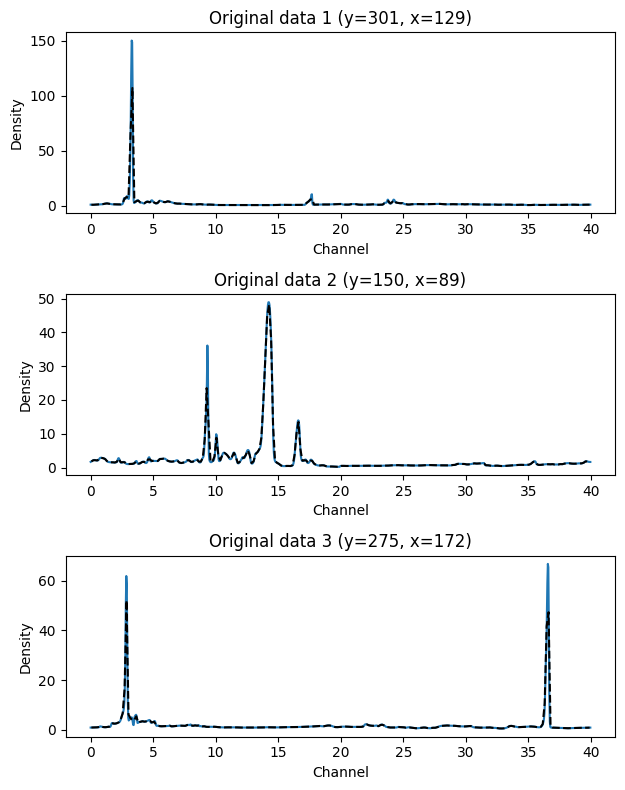

In [ ]:
# Extract spectra from the original data cube and reshaped array
original_data = np.array([dens[:, y, x] for y, x in zip(ys, xs)])
reshaped_data = dens_rs[indices]

# Plot the original and reshaped spectra
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(n, 2, 2 * i + 1)
    plt.plot(L, original_data[i])
    plt.plot(L128, reshaped_data[i], 'k--')
    plt.title(f'Original data {i+1} (y={ys[i]}, x={xs[i]})')
    plt.xlabel('Channel')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

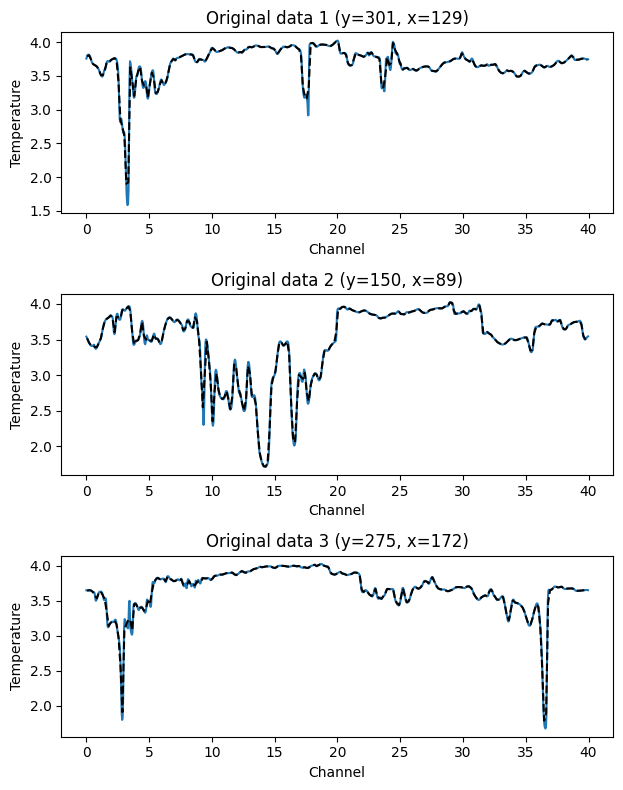

In [ ]:
# Extract spectra from the original data cube and reshaped array
original_data = np.array([temp[:, y, x] for y, x in zip(ys, xs)])
reshaped_data = temp_rs[indices]

# Plot the original and reshaped spectra
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(n, 2, 2 * i + 1)
    plt.plot(L, original_data[i])
    plt.plot(L128, reshaped_data[i], 'k--')
    plt.title(f'Original data {i+1} (y={ys[i]}, x={xs[i]})')
    plt.xlabel('Channel')
    plt.ylabel('Temperature')

plt.tight_layout()
plt.show()

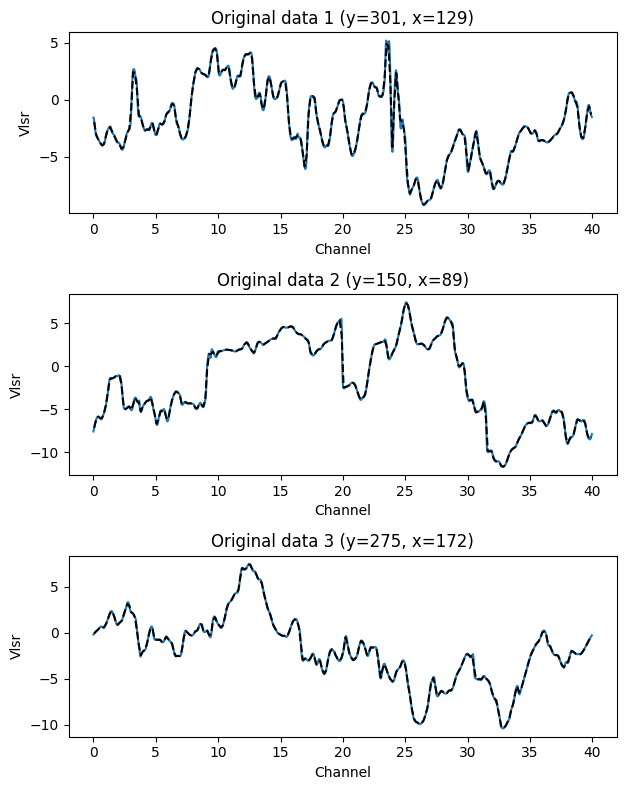

In [ ]:
# Extract spectra from the original data cube and reshaped array
original_data = np.array([velz[:, y, x] for y, x in zip(ys, xs)])
reshaped_data = velz_rs[indices]

# Plot the original and reshaped spectra
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(n, 2, 2 * i + 1)
    plt.plot(L, original_data[i])
    plt.plot(L128, reshaped_data[i], 'k--')
    plt.title(f'Original data {i+1} (y={ys[i]}, x={xs[i]})')
    plt.xlabel('Channel')
    plt.ylabel('Vlsr')

plt.tight_layout()
plt.show()

# Preprocess

In [ ]:
# I will leave this blank

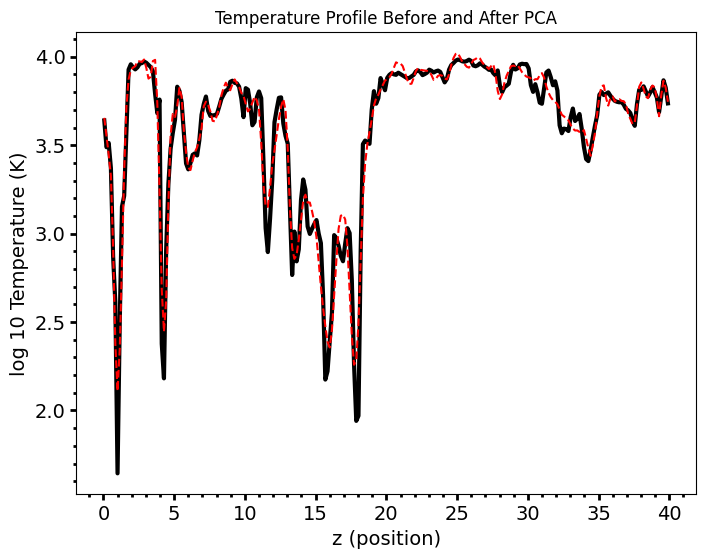

In [ ]:
i = 123
j = 111

fig, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

ax3.plot(L128, temp_rs[j*512+i, :], lw=3, label='Original Temperature Profile', color='k')
ax3.plot(L128, temp_rs_reconstructed[j*512+i, :], ls='--', label='Reconstructed Profile (PCA)', color='r')

ax3.set_title('Temperature Profile Before and After PCA')
ax3.set_xlabel('z (position)', fontsize=14)
ax3.set_ylabel('log 10 Temperature (K)', fontsize=14)


ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


plt.show()

# Defining an `embedding_net`

SBI will apply an inference procedure to the output from the simulator model to determine the posterior distribution of $\theta_E$ given an observation of $x$ (the tb spectrum). Unfortunately, at present, the output data lives in a 256 dimensional space (256 channels). To avoid working directly with $x$ (because high-dimensional images are very computationally expensive), we will use a convolutional neural network (CNN) that takes the 256-channel spectra as input and encodes them into 64-dimensional feature vectors. This embedding net allows us to change the output dimension of the data $x$ from 256 to 64.

We define and instantiate the CNN as follows:

In [ ]:
class SummaryNet(nn.Module):

    def __init__(self):
        super().__init__()
        # 2D convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        # Maxpool layer that reduces 256 image to ??
        self.pool = nn.MaxPool1d(kernel_size=8, stride=8)
        # Fully connected layer taking as input the 6 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features=8*8*8, out_features=64)

    def forward(self, x):
        # print('input', x.shape)
        x = x.view(-1, 1, 256)
        # print('after view', x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        # print('after pool', x.shape)
        x = x.view(-1, 8*8*8)
        x = F.relu(self.fc(x))
        return x



embedding_net = SummaryNet()

# print a summary of the embedding net
summary(embedding_net, (1, 1, 256))

# The inference procedure

With the `embedding_net` defined and instantiated, we can follow the usual workflow of an inference procedure in `sbi`. The `embedding_net` object appears as an input argument when instantiating the neural density estimator with `utils.posterior_nn`.

In [ ]:
prior_low = -8.5
prior_high = 6.
num_dim = 1

# Assume a uniform prior for simplicity
params_length = 1*npca_comps
prior = utils.BoxUniform(low=prior_low*torch.ones(params_length),
                         high=prior_high*torch.ones(params_length),
                         device=device
                         )

In [ ]:
samp = prior.sample()
samp.shape

torch.Size([64])

<Figure size 640x480 with 0 Axes>

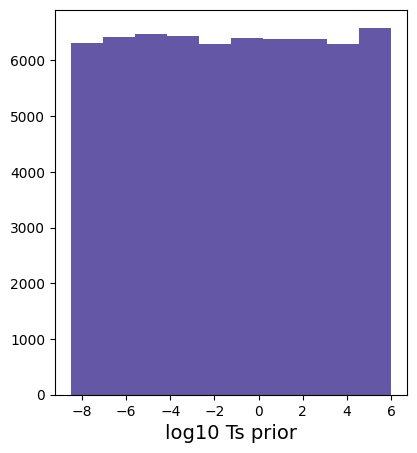

In [ ]:
# visualize the prior via sampling
nsamples = 1000
ts_sample = np.zeros((nsamples, npca_comps))
for i in range(nsamples):
  samp = prior.sample()
  ts_sample[i] = np.array(samp)

plt.clf()


ts_sample = ts_sample.flatten()
fig = plt.figure(figsize = (10,5))
ax0 = fig.add_subplot(121)
ax0.hist(ts_sample, color = '#6457A6')
ax0.set_xlabel('log10 Ts prior', fontsize=14)
plt.show()

## Make a SBI-wrapper on the simulator object
This is necessary if you're using any sort of embedding network, because you'll need to join the embedding network together with the flow estimator network into one neural posterior estimator to rule them all.

In [ ]:
# Total number of indices
total_indices = ny * nx

# Generate all possible indices
all_indices = np.arange(total_indices)

# Shuffle the indices
np.random.shuffle(all_indices)

# Split into two different sets of indices
train_indices = all_indices[:n_train]
test_indices = all_indices[n_train:(n_train + n_test)]

In [ ]:
train_spectra = cube_rs[train_indices, :]
test_spectra = cube_rs[test_indices, :]
train_params = temp_rs_pca[train_indices, :]

In [ ]:
# Train spectra: Tb spectra here
train_spectra = torch.from_numpy(np.asarray(train_spectra, dtype = 'float32'))
test_spectra = torch.from_numpy(np.asarray(test_spectra, dtype = 'float32'))

# train params: Tk here
train_params = torch.from_numpy(np.asarray(train_params, dtype = 'float32'))

test_ts_spectra = temp_rs[test_indices, :]
test_tau_spectra = tau_cube_rs[test_indices, :]

In [ ]:
# For training
train_params = train_params.to(device)
train_spectra = train_spectra.to(device)

# For testing
test_spectra = test_spectra.to(device)

## Instantiate the neural density estimator (NDE)
A NDE is the internal mechanism that associates thetas with xs. Again, the hidden features of the NDE are learned along with those of the embedding network.

Here we're using a masked autoregressive flow (MAF) for the NDE. For more information about MAFs, see the slides by Jason Poh: LINK.

We're using five hidden features for each unit of the MAF and two transforms, which are invertible neural density transforms.


In [ ]:
neural_posterior = posterior_nn(model='maf',
                                embedding_net=embedding_net,
                                hidden_features=5,
                                num_transforms=2)

## Set up the inference procedure
We will use the SNPE-C procedure, which is sequential neural posterior estimation with C option.

In [ ]:
inference = SNPE(prior=prior, device=device, show_progress_bars=True, density_estimator=neural_posterior)

## Run the inference procedure
First simulate 1000 data, parameter pairs. Then, train the inference object using this dataset. Finally, build the posterior.

This should take a minute or so.

In [ ]:
density_estimator = # I will leave this blank
posterior = # I will leave this blank

print('Finished Training...')
print('Sampling...')

 Neural network successfully converged after 949 epochs.Finished Training...
Sampling...


In [ ]:
# Save the density estimator and inference object
inference_path = checkpoint_path / 'tk_snpe_inference.pkl'
posterior_path = checkpoint_path / 'tk_snpe_posterior.pt'
density_path = checkpoint_path / 'tk_density_estimator.pt'

In [ ]:
# Reload the inference object
with open(inference_path, "rb") as f:
    inference = pickle.load(f)


# Reload the density estimator
density_estimator = torch.load(density_path)

# Reload the posterior for inference
posterior = torch.load(posterior_path)

<ipython-input-77-ded522b90fa8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  posterior = torch.load(posterior_path)
<ipython-input-77-ded522b90fa8>:5: FutureWarning: You

In [ ]:
# Save the inference object with pickle
with open(inference_path, "wb") as f:
    pickle.dump(inference, f)


# Save the posterior separately (recommended for large models)
torch.save(posterior, posterior_path)

# Save the density estimator
torch.save(density_estimator, density_path)

<ipython-input-189-09d6ce237eca>:3: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickle.dump(inference, f)


# Test the framework: 3 cases
Using this generated image, draw 10k samples from the posterior that you have already trained. Because this method is amortized, it's relatively fast to draw from this pre-trained posterior density each time you have a new observation.

In [ ]:
test_indices = [3, 19, 33]
ts_med_spectrum_log_arr = np.zeros((3, 256))
ts_pred_std_log_arr = np.zeros((3, 256))

for k, test_idx in enumerate(test_indices):
    test_spectrum = test_spectra[test_idx].unsqueeze(0)
    samples = posterior.set_default_x(test_spectrum).sample((1024,))
    print(f'{test_idx}: Finish sampling...')

    ts_pred_pca_spectra = samples.cpu().numpy()
    ts_pred_spectra_log = # I will leave this blank
    ts_med_spectrum_log = # I will leave this blank
    ts_pred_std_log     = # I will leave this blank

    ts_med_spectrum_log_arr[k, :] = # I will leave this blank
    ts_pred_std_log_arr[k, :] = # I will leave this blank


Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

3: Finish sampling...


Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

19: Finish sampling...


Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

33: Finish sampling...


The figure below shows the statistics of the generated samples. The red line shows the true value.

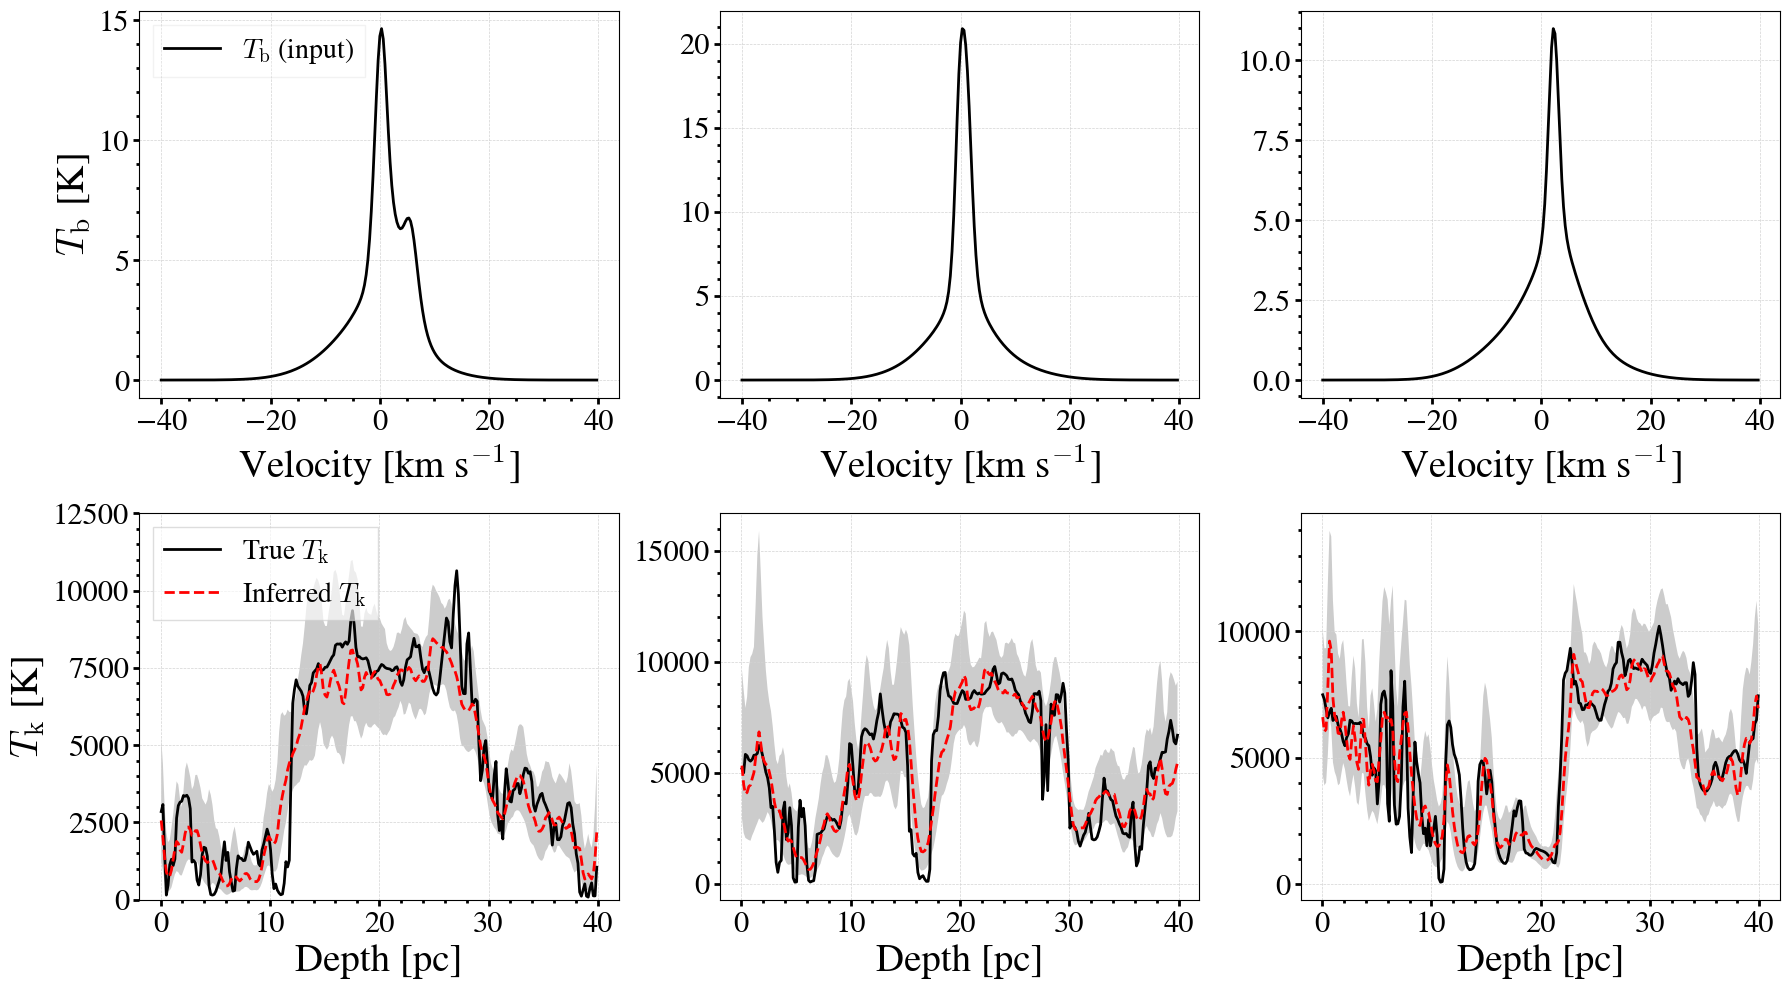

In [ ]:
#
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharex=False)


xlablesize = 28
xtlbsize = 22

kid = 0
test_idx = test_indices[kid]

ax1 = axs[0,0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='$T_\mathrm{b}$ (input)')

ax1.set_xlabel('Velocity [km s$^{-1}$]', fontsize=xlablesize)
ax1.set_ylabel('$T_\mathrm{b}$ [K]', fontsize=xlablesize)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=xtlbsize, pad=4)
ax1.tick_params(axis='y', labelsize=xtlbsize)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax1.legend(loc='upper left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=20)


#
ax4 = axs[1,0]
# I will leave this blank



ax4.set_xlabel('Depth [pc]', fontsize=xlablesize)
ax4.set_ylabel('$T_\mathrm{k}$ [K]', fontsize=xlablesize)

ax4.minorticks_on()
ax4.tick_params(axis='x', labelsize=xtlbsize, pad=4)
ax4.tick_params(axis='y', labelsize=xtlbsize)
ax4.tick_params(which='both', width=2)
ax4.tick_params(which='major', length=4)
ax4.tick_params(which='minor', length=2)

ax4.set_ylim(0, 12500)

ax4.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax4.legend(loc='upper left', fancybox=False, framealpha=0.65, labelcolor='k', fontsize=20)




####
kid = 1
test_idx = test_indices[kid]

ax1 = axs[0,1]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='$T_\mathrm{b}(v)$ (input)')

ax1.set_xlabel('Velocity [km s$^{-1}$]', fontsize=xlablesize)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=xtlbsize, pad=4)
ax1.tick_params(axis='y', labelsize=xtlbsize)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax4 = axs[1,1]
# I will leave this blank



ax4.set_xlabel('Depth [pc]', fontsize=xlablesize)

ax4.minorticks_on()
ax4.tick_params(axis='x', labelsize=xtlbsize, pad=4)
ax4.tick_params(axis='y', labelsize=xtlbsize)
ax4.tick_params(which='both', width=2)
ax4.tick_params(which='major', length=4)
ax4.tick_params(which='minor', length=2)

ax4.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)




####
kid = 2
test_idx = test_indices[kid]

ax1 = axs[0,2]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='$T_\mathrm{b}(v)$ (input)')

ax1.set_xlabel('Velocity [km s$^{-1}$]', fontsize=xlablesize)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=xtlbsize, pad=4)
ax1.tick_params(axis='y', labelsize=xtlbsize)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)

ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax4 = axs[1,2]
# I will leave this blank


ax4.set_xlabel('Depth [pc]', fontsize=xlablesize)

ax4.minorticks_on()
ax4.tick_params(axis='x', labelsize=xtlbsize, pad=4)
ax4.tick_params(axis='y', labelsize=xtlbsize)
ax4.tick_params(which='both', width=2)
ax4.tick_params(which='major', length=4)
ax4.tick_params(which='minor', length=2)

ax4.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)




# Adjust layout to prevent overlap
plt.tight_layout()

# plt.savefig(saury_data_path / '.png', bbox_inches='tight')
# Show the plot
plt.show()

# Draw from the posterior
Using this generated image, draw 10k samples from the posterior that you have already trained. Because this method is amortized, it's relatively fast to draw from this pre-trained posterior density each time you have a new observation.

In [ ]:
test_idx = 3
test_spectra[test_idx].shape

torch.Size([256])

In [ ]:
test_spectrum = test_spectra[test_idx].unsqueeze(0)
samples = posterior.sample((256,))
print('Finish sampling...')

Drawing 256 posterior samples:   0%|          | 0/256 [00:00<?, ?it/s]

Finish sampling...


In [ ]:
ts_pred_pca_spectra = samples.cpu().numpy()
ts_pred_spectra_log = # I will leave this blank
ts_med_spectrum_log = # I will leave this blank
ts_pred_std_log     = # I will leave this blank

Plotting results...


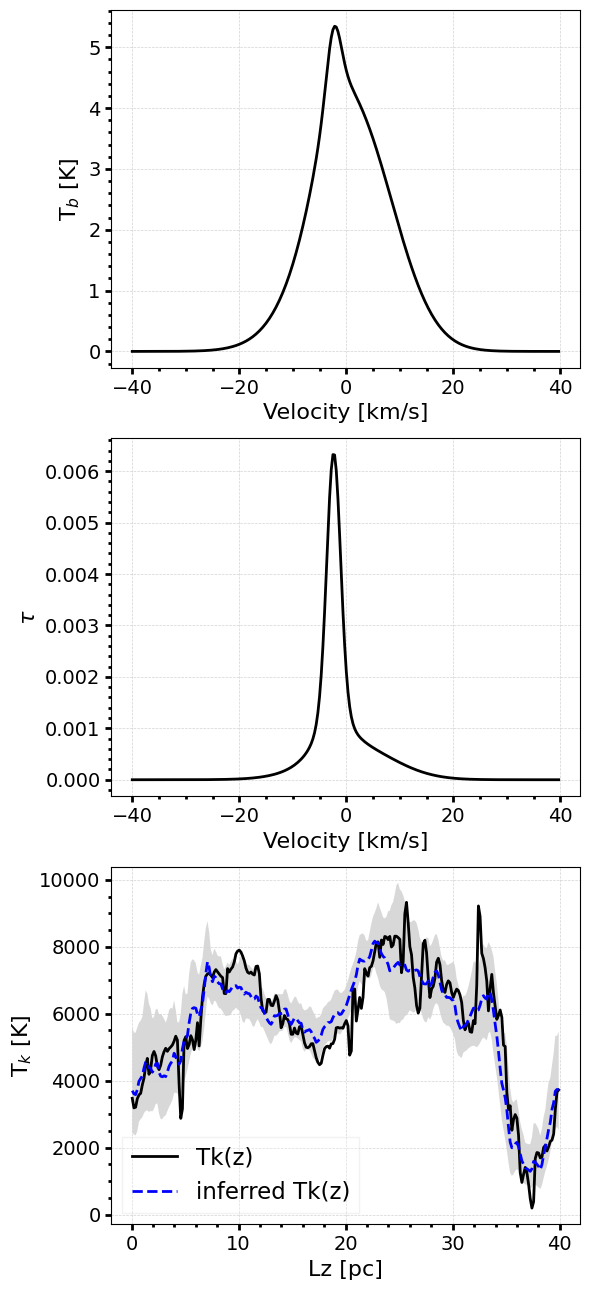

In [ ]:
print('Plotting results...')

#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='Tb')

# ax1.set_title('Training set')
ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel(r'$\tau$', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(v, test_tau_spectra[test_idx], 'k-', lw=2, label=r'$\tau$')

ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)


ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax3 = axs[2]
# I will leave this blank


ax3.set_xlabel('Lz [pc]', fontsize=16)
ax3.set_ylabel('T$_k$ [K]', fontsize=16)

ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)



# Adjust layout to prevent overlap
plt.tight_layout()



# Adjust layout to prevent overlap
plt.tight_layout()

# plt.savefig(saury_data_path / '.png', bbox_inches='tight')
# Show the plot
plt.show()

# Draw from the posterior
Using this generated image, draw 10k samples from the posterior that you have already trained. Because this method is amortized, it's relatively fast to draw from this pre-trained posterior density each time you have a new observation.

In [ ]:
test_idx = 3
test_spectra[test_idx].shape

torch.Size([256])

In [ ]:
test_spectrum = test_spectra[test_idx].unsqueeze(0)  # Use the first test spectrum as an example
samples = posterior..sample((256,))
print('Finish sampling...')

Drawing 1024 posterior samples:   0%|          | 0/1024 [00:00<?, ?it/s]

Finish sampling...


In [ ]:
ts_pred_pca_spectra = samples.cpu().numpy()
ts_pred_spectra_log = # I will leave this blank
ts_med_spectrum_log = # I will leave this blank
ts_pred_std_log     = # I will leave this blank

Plotting results...


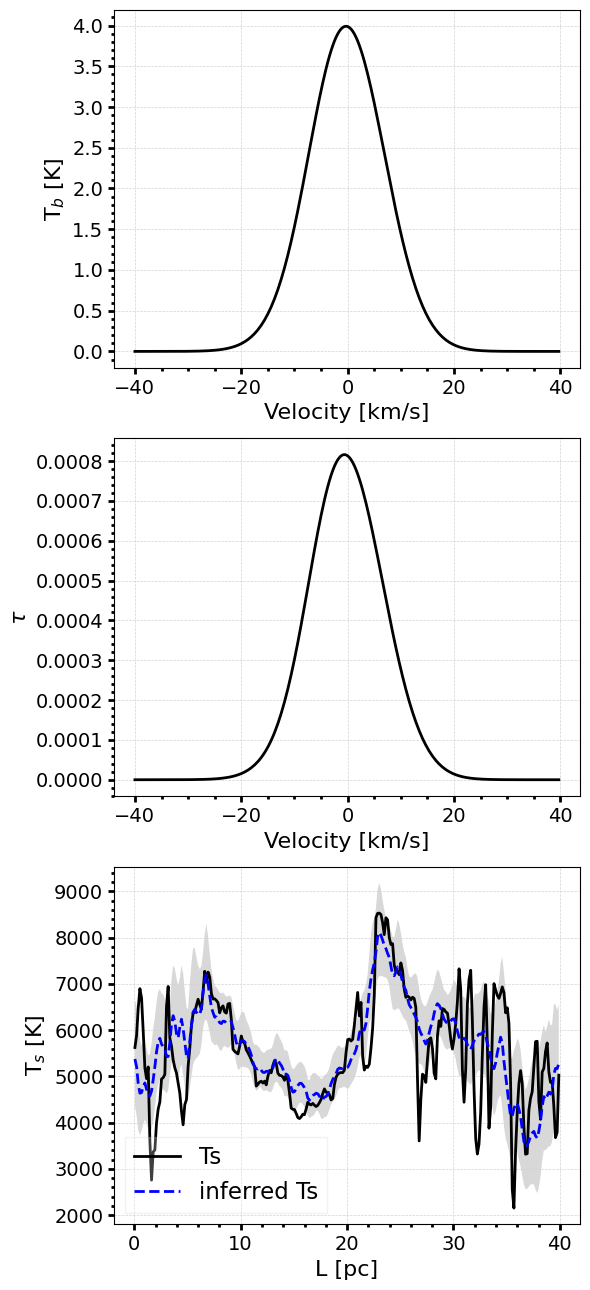

In [ ]:
print('Plotting results...')

#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='Tb')

ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel(r'$\tau$', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(v, test_tau_spectra[test_idx], 'k-', lw=2, label=r'$\tau$')

ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)


ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax3 = axs[2]
# I will leave this blank


# ax3.set_title('Training set')
ax3.set_xlabel('Lz [pc]', fontsize=16)
ax3.set_ylabel('T$_k$ [K]', fontsize=16)

ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)



# Adjust layout to prevent overlap
plt.tight_layout()



# Adjust layout to prevent overlap
plt.tight_layout()

# plt.savefig(saury_data_path / '.png', bbox_inches='tight')
# Show the plot
plt.show()

# Draw from the posterior
Using this generated image, draw 10k samples from the posterior that you have already trained. Because this method is amortized, it's relatively fast to draw from this pre-trained posterior density each time you have a new observation.

In [ ]:
test_idx = 99
test_spectra[test_idx].shape

torch.Size([256])

In [ ]:
test_spectrum = test_spectra[test_idx].unsqueeze(0)  # Use the first test spectrum as an example
samples = posterior..sample((256,))
print('Finish sampling...')

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Finish sampling...


In [ ]:
ts_pred_pca_spectra = samples.cpu().numpy()
ts_pred_spectra_log = # I will leave this blank
ts_med_spectrum_log = # I will leave this blank
ts_pred_std_log     = # I will leave this blank

Plotting results...


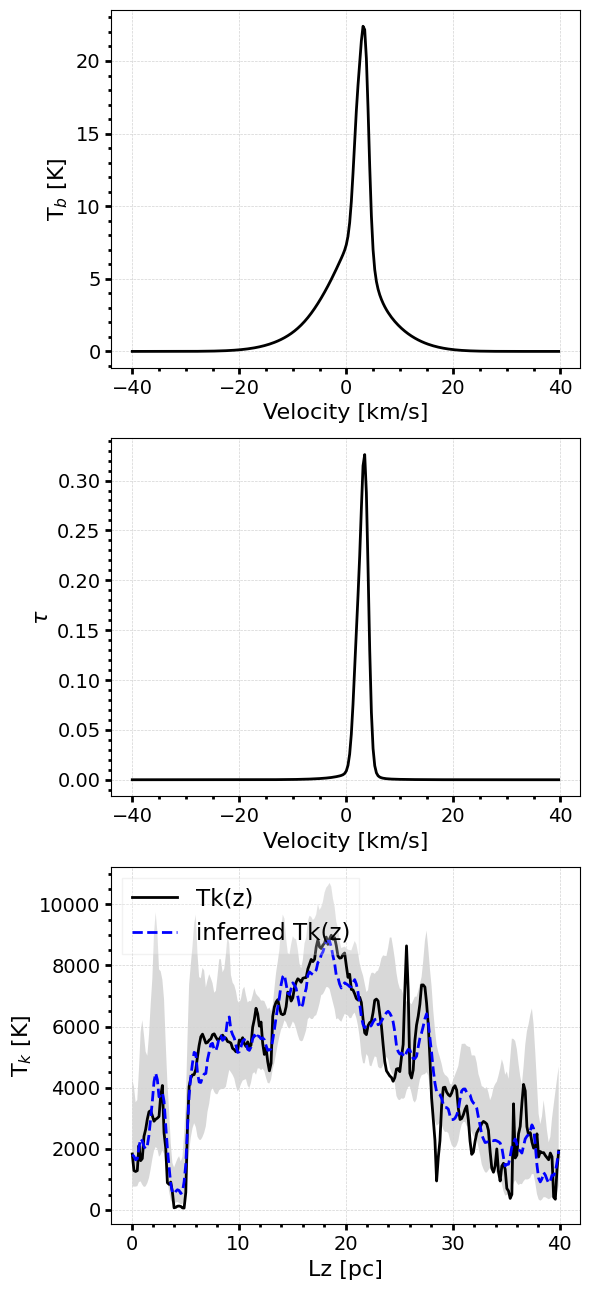

In [ ]:
print('Plotting results...')

#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='Tb')

ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel(r'$\tau$', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(v, test_tau_spectra[test_idx], 'k-', lw=2, label=r'$\tau$')

# ax2.set_title('Training set')
ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)


ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax3 = axs[2]
# I will leave this blank


# ax3.set_title('Training set')
ax3.set_xlabel('Lz [pc]', fontsize=16)
ax3.set_ylabel('T$_k$ [K]', fontsize=16)

ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)



# Adjust layout to prevent overlap
plt.tight_layout()



# Adjust layout to prevent overlap
plt.tight_layout()

# plt.savefig(saury_data_path / '.png', bbox_inches='tight')
# Show the plot
plt.show()

# Draw from the posterior
Using this generated image, draw 10k samples from the posterior that you have already trained. Because this method is amortized, it's relatively fast to draw from this pre-trained posterior density each time you have a new observation.

In [ ]:
test_idx = 7
test_spectra[test_idx].shape

In [ ]:
test_spectrum = test_spectra[test_idx].unsqueeze(0)  # Use the first test spectrum as an example
samples = posterior..sample((256,))
print('Finish sampling...')

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Finish sampling...


In [ ]:
ts_pred_pca_spectra = samples.cpu().numpy()
ts_pred_spectra_log = # I will leave this blank
ts_med_spectrum_log = # I will leave this blank
ts_pred_std_log     = # I will leave this blank

Plotting results...


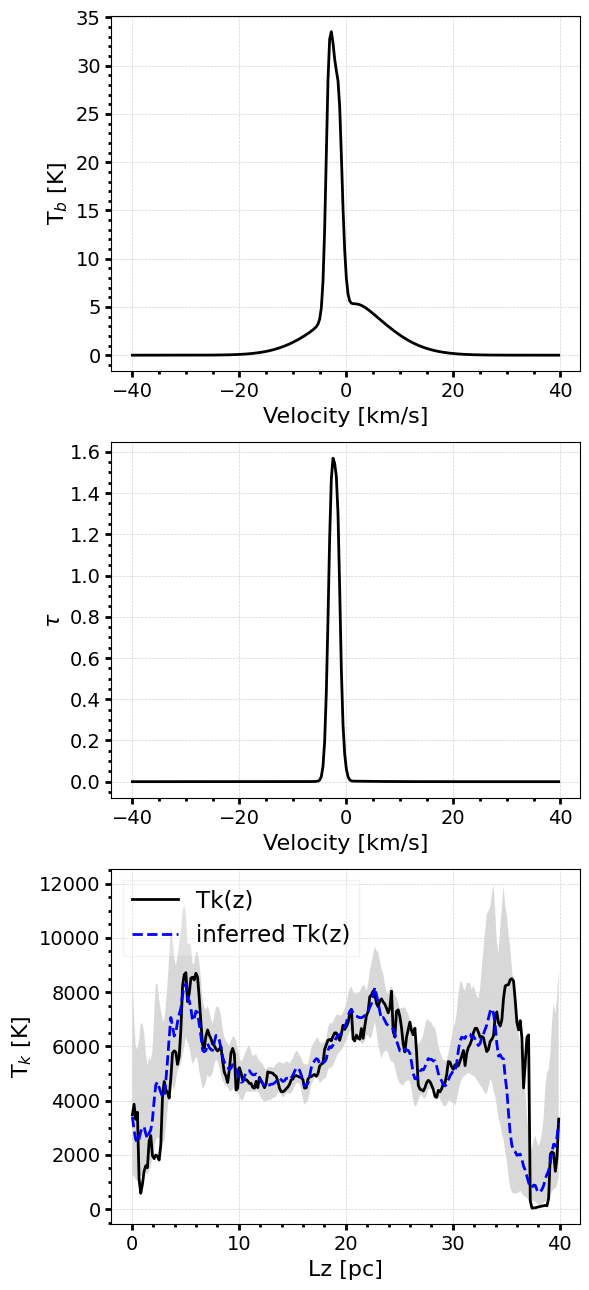

In [ ]:
print('Plotting results...')

#
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))

ax1 = axs[0]
ax1.plot(v, test_spectra.numpy()[test_idx], 'k-', lw=2, label='Tb')

# ax1.set_title('Training set')
ax1.set_xlabel('Velocity [km/s]', fontsize=16)
ax1.set_ylabel(r'$\tau$', fontsize=16)
ax1.set_ylabel('T$_b$ [K]', fontsize=16)

ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=14, pad=4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=4)
ax1.tick_params(which='minor', length=2)


ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


#
ax2 = axs[1]
ax2.plot(v, test_tau_spectra[test_idx], 'k-', lw=2, label=r'$\tau$')

ax2.set_xlabel('Velocity [km/s]', fontsize=16)
ax2.set_ylabel(r'$\tau$', fontsize=16)

ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=14, pad=4)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=4)
ax2.tick_params(which='minor', length=2)


ax2.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



#
ax3 = axs[2]
# I will leave this blank


# ax3.set_title('Training set')
ax3.set_xlabel('Lz [pc]', fontsize=16)
ax3.set_ylabel('T$_k$ [K]', fontsize=16)

ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=14, pad=4)
ax3.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=4)
ax3.tick_params(which='minor', length=2)


ax3.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax3.legend(loc='lower left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=16.5)



# Adjust layout to prevent overlap
plt.tight_layout()



# Adjust layout to prevent overlap
plt.tight_layout()

# plt.savefig(saury_data_path / '.png', bbox_inches='tight')
# Show the plot
plt.show()